# 数据预处理

## 数据加载

In [107]:
from sklearn.model_selection import train_test_split

def load_one_file(filename):
    with open(filename, encoding='utf8') as f:
        return [str(i.strip()) for i in f.readlines()]  # 确保每一行都被转换为字符串

def load_all_files():
    x_train = []
    y_train = []
    x_test = []
    y_test = []

 
    # Load and label the data
    x_normal = load_one_file('../data/normal.txt')
    x_weak = load_one_file('../data/weak.txt')
    x_token = load_one_file('../data/tokens.txt')

    dataNum = min(len(x_normal), len(x_weak), len(x_token))

    y_normal = [0] * dataNum 
    y_weak = [1] * dataNum 
    y_token = [2] * dataNum


    # Combine all data
    x = x_normal[:dataNum] + x_weak[:dataNum] + x_token[:dataNum]
    y = y_normal + y_weak + y_token

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_all_files()
print(f"Training data size: {len(x_train)}")
print(f"Test data size: {len(x_test)}")

Training data size: 4101
Test data size: 1026


In [108]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'x_train':x_train, 
              'y_train':y_train,
              'x_test':x_test+['']*int(len(x_train)-len(x_test)),
              'y_test':y_test+[0]*int(len(x_train)-len(x_test)) })
df.head()

,x_train,y_train,x_test,y_test
0,"Oberman,",0,UqZBpD3n3iTIBgBW=v1-1r6g8WcQKe,2
1,She's,0,Hm_lpvt_00108d8049c69b90aefda9703dee7b4e=17394...,2
2,JSESSIONID_JAVA=517DC05AE1AE460D92FF96149D251E9B,2,cc67a8d4abbc6ab7c6d899f8ed6892fe=a790ec26c6a04...,2
3,Hm_lvt_2024f59541ef1c59b5e53289ffdaaebb=173923...,2,wants,0
4,etihad.10,1,Hm_lpvt_50be06609cf92e6d07fd1e3a8376dde0=17394...,2


## TF-IDF

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 使用 TF-IDF 进行特征提取
tfidf_vectorizer = TfidfVectorizer(max_features=500, decode_error='ignore', strip_accents='ascii')
x_train = tfidf_vectorizer.fit_transform(x_train)
x_test = tfidf_vectorizer.transform(x_test)


## word2vec

In [59]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

def preprocess_text(text):
    return simple_preprocess(text)

x_train_preprocessed = [preprocess_text(doc) for doc in x_train]
x_test_preprocessed = [preprocess_text(doc) for doc in x_test]

# 训练 Word2Vec 模型
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.build_vocab(x_train_preprocessed+x_test_preprocessed)
# 将文本转换为向量
def document_vector(doc, model):
    doc_vec = np.zeros(model.vector_size)
    num_words = 0
    for word in doc:
        if word in model.wv:
            doc_vec += model.wv[word]
            num_words += 1
    if num_words > 0:
        doc_vec /= num_words
    return doc_vec

x_train = np.array([document_vector(doc, word2vec_model) for doc in x_train_preprocessed])
x_test = np.array([document_vector(doc, word2vec_model) for doc in x_test_preprocessed])

## 词袋模型

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=500

vectorizer = CountVectorizer(
                                decode_error='ignore',
                                strip_accents='ascii',
                                max_features=max_features,
                                max_df=1.0,
                                min_df=1 )
print(vectorizer)
x_train=vectorizer.fit_transform(x_train)
x_train=x_train.toarray()

CountVectorizer(decode_error='ignore', max_features=500, strip_accents='ascii')


In [110]:
vocabulary=vectorizer.vocabulary_
# 复用vocabulary对测试数据集进行词袋化处理
vectorizer = CountVectorizer(
                                decode_error='ignore',
                                strip_accents='ascii',
                                vocabulary=vocabulary,
                                max_df=1.0,
                                min_df=1 )
print(vectorizer)
x_test=vectorizer.fit_transform(x_test)
x_test=x_test.toarray()

CountVectorizer(decode_error='ignore', strip_accents='ascii',
                vocabulary={'00cfe77092104c99': 0, '021f2a73d5af': 1,
                            '035559e0': 2, '0653d1d7e9c2': 3, '0bde2425f512': 4,
                            '0c2d464c622b4f9b9a81eb89b45061ae': 5,
                            '0dc6d096': 6, '10a07a9ab7e6': 7, '123': 8,
                            '14b78bb6dff8': 9, '15f8': 10, '1602': 11,
                            '1661877752': 12, '172421156': 13, '1736392260': 14,
                            '1737338170': 15, '1738651153': 16,
                            '1738984680': 17, '1738985495': 18,
                            '1738985539': 19, '1739155025': 20,
                            '1739164319': 21, '1739169338': 22,
                            '1739173573': 23, '1739173604': 24,
                            '1739176775': 25, '1739240620': 26,
                            '1739257204': 27, '1739260420': 28,
                            '1739265925': 29, ..

In [111]:
df = pd.DataFrame(x_train) # 每一行代表一个文档，每一列代表一个词汇，矩阵中的值表示词汇在文档中出现的次数。
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 机器学习

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

def train_model(classifier, x_train, y_train):
    classifier.fit(x_train, y_train)
    train_score = classifier.score(x_train, y_train)
    print("训练准确率：{}".format(train_score))
    return classifier

def test_model(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    print("准确率：{}".format(metrics.accuracy_score(y_test, y_pred)))
    print("分类报告：\n{}".format(metrics.classification_report(y_test, y_pred)))
    
    # 创建一个新的图形对象
    plt.figure(figsize=(2, 2))
    
    # 绘制混淆矩阵
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    
    # 显示图形
    plt.title('Confusion Matrix')
    plt.show()

## Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=2000)
model =train_model(lg, x_train, y_train)

训练准确率：0.7056815410875397


准确率：0.6549707602339181
分类报告：
              precision    recall  f1-score   support

           0       0.97      0.09      0.16       358
           1       0.47      1.00      0.64       313
           2       0.99      0.93      0.96       355

    accuracy                           0.65      1026
   macro avg       0.81      0.67      0.59      1026
weighted avg       0.83      0.65      0.58      1026



<Figure size 200x200 with 0 Axes>

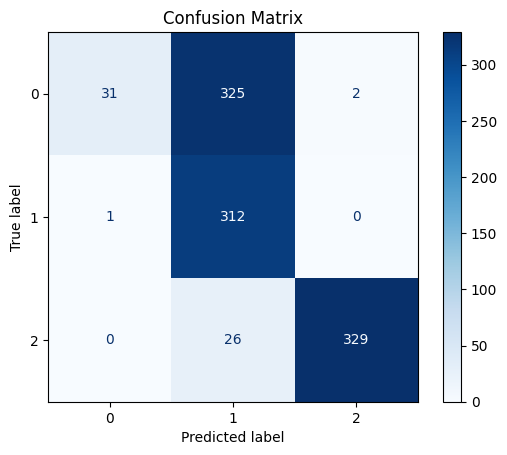

In [115]:
test_model(model, x_test, y_test)

## 贝叶斯

In [116]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

tag = 'TFDF'
if tag == 'TFIDF':
    x_train = x_train.toarray()
    x_test = x_test.toarray()
model = train_model(nb, x_train, y_train)

训练准确率：0.7042184832967568


In [98]:
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=10)
}

# 使用 GridSearchCV 进行网格搜索
grid_search = GridSearchCV(nb, param_grid, refit=True, verbose=1, cv=10)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# 使用最佳参数训练模型
model = grid_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'var_smoothing': 0.01}
Best Cross-validation Score: 0.7010491958934189


准确率：0.6569200779727096
分类报告：
              precision    recall  f1-score   support

           0       0.97      0.09      0.17       358
           1       0.47      1.00      0.64       313
           2       1.00      0.93      0.96       355

    accuracy                           0.66      1026
   macro avg       0.81      0.67      0.59      1026
weighted avg       0.83      0.66      0.59      1026



<Figure size 200x200 with 0 Axes>

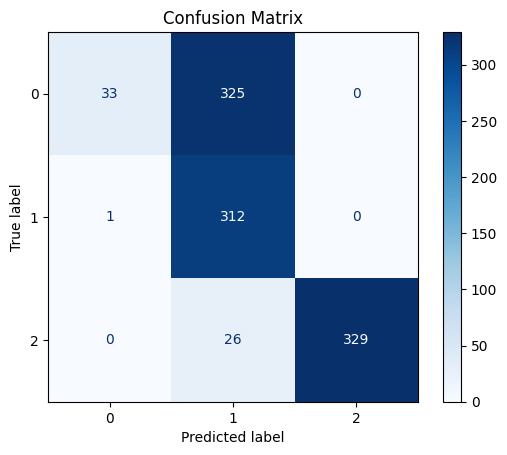

In [117]:
test_model(model, x_test, y_test)

## SVM

In [120]:
from sklearn import svm

sv = svm.SVC()
model = train_model(sv, x_train, y_train)

训练准确率：0.7056815410875397


In [92]:

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'gamma': [1, 0.1, 0.01, 0.001]
}

sv = svm.SVC()

grid_search = GridSearchCV(sv, param_grid, refit=True, verbose=1, cv=10)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)
# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'gamma': 1}
Best Cross-validation Score: 0.7022687080885407


准确率：0.6549707602339181
分类报告：
              precision    recall  f1-score   support

           0       0.97      0.09      0.16       358
           1       0.47      1.00      0.64       313
           2       0.99      0.93      0.96       355

    accuracy                           0.65      1026
   macro avg       0.81      0.67      0.59      1026
weighted avg       0.83      0.65      0.58      1026



<Figure size 200x200 with 0 Axes>

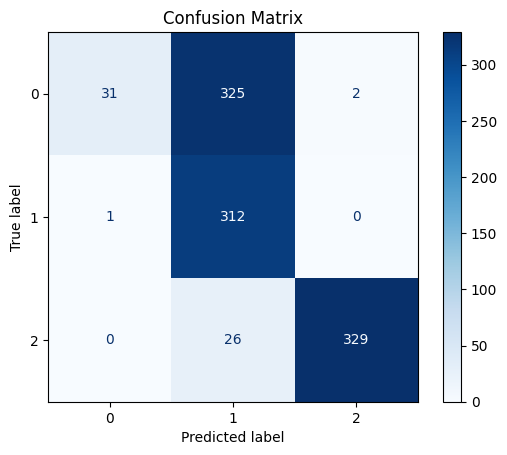

In [121]:
test_model(model, x_test, y_test)

## MLP

In [118]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs',
                    alpha=0.01,
                    hidden_layer_sizes = (5, 2),
                    random_state = 1)
model = train_model(clf, x_train, y_train)

训练准确率：0.6193611314313582


准确率：0.5828460038986355
分类报告：
              precision    recall  f1-score   support

           0       0.75      0.01      0.02       358
           1       0.42      1.00      0.59       313
           2       0.99      0.80      0.88       355

    accuracy                           0.58      1026
   macro avg       0.72      0.60      0.50      1026
weighted avg       0.73      0.58      0.49      1026



<Figure size 200x200 with 0 Axes>

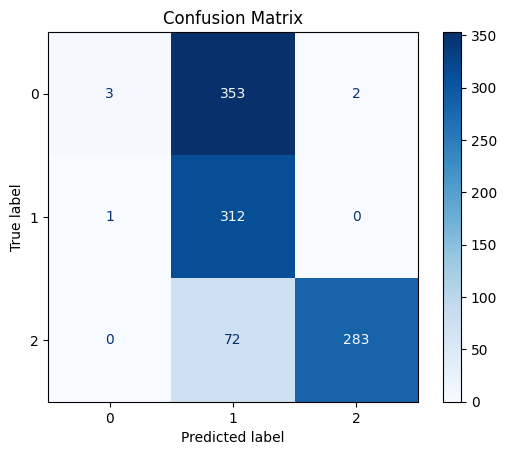

In [119]:
test_model(model, x_test, y_test)

## 保存模型

In [ ]:
import joblib

# 保存模型和向量化器
joblib.dump(model, 'GaussianNB.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# 深度学习

## Bert

In [1]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

input_ids = torch.tensor(tokenizer.encode("我是学生")).unsqueeze(0)  # Batch size 1
output = model(input_ids)
Sequence_output = output[0]
pooled_output = output[1]
print(Sequence_output.shape)
print(pooled_output.shape)

ModuleNotFoundError: No module named 'transformers'

In [ ]:
input_ids

In [ ]:
Sequence_output[0][1]